In [1]:
from weaPoints import WeaPoints, InterpolationMethod
from anemosData import TsNcWindData, WindDataKind
import numpy as np
import xarray
import pandas

# Loading Anemos Data

<AxesSubplot:xlabel='time'>

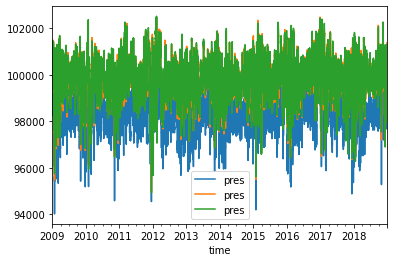

In [3]:
data = TsNcWindData(
            wind_data_kind=WindDataKind.AIRPRESSURE,
        ).get_winddata()

x = [-222567, 111111, 222222]

y = [-222567, 111111, 222222]

level = [102,73,122]

data.interp(x=x,y=y,level=level)#.pres[0].to_pandas()
#series = list()
#for x, y, level in zip(x,y,level):
#    series.append(data.interp(x=x,y=y,level=level).to_pandas().pres)

#pandas.concat(series, axis=1).resample("7d").plot()

# Loading Points

In [ ]:
size = 2
lon = np.around(np.random.uniform(6.0, 14.0, size=size),1)
lat = np.around(np.random.uniform(48.0, 55.0, size=size),1)
lat_lon_coor = np.stack((lat, lon), axis=1)
level = np.around(np.random.uniform(80.0, 140.0, size=size),1)

testPoints = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = level,
    wea_types = ["test_wea"] * size,
    interpolation_method = [InterpolationMethod.LINEAR] * size,
)

testPoints.point_list[:5]

# Loading Leistungskennlinen

In [ ]:
path = r"./wea_data/example/test_wea.nc"
power_curves = xarray.open_dataset(path)
power_curves["test_wea"]

In [ ]:
anlage = (24503 * 3252 * 8) / 1024 / 1024

n = 100
größe = (anlage * n) / 1024

print(f"Speicherbedarf von interpolierten Leistungskennlinien {n} Anlagen: {round(größe, 3)} Gigabyte")

# Get Time series

In [ ]:
testPoints.get_power_output(power_curves=power_curves)

In [ ]:
testPoints.point_list[0].power_time_series#.values#.plot()#.resample(time="7d").mean().plot(figsize=(20,3))

In [4]:
variable = "wspd"
mf = True

path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/{}.10L.{}.ts.nc"
#path = f"/uba/transfer/UBA-Windatlas/TSNC-Format/{variable}.10L.*.ts.nc"

if mf:
    path = path.format(variable, "*")
    data = xarray.open_mfdataset(path, engine="h5netcdf", parallel=True)

else:
    path = path.format(variable, "2016")
    data = xarray.open_dataset(path, engine="h5netcdf",)
print(path)
#x = xarray.DataArray([5, 78, 111], dims='z')

#y = xarray.DataArray([99, 189, 32], dims='z')
 
#level = xarray.DataArray([99, 189, 32], dims='z')

data#.info
#data.interp(x=x,y=y,level=level).pres[0].to_pandas()
#series = list()
#for x, y, level in zip(x,y,level):
#    series.append(data.interp(x=x,y=y,level=level).to_pandas()[variable])

#pandas.concat(series, axis=1)#.resample("7d").plot()

#.time.values #= self._assign_new_lambert_coor(data)

/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc


<xarray.Dataset>
Dimensions:  (y: 310, x: 225, time: 525888, level: 10)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(310, 225), meta=np.ndarray>
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
  * x        (x) int16 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223 224
  * y        (y) int16 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * level    (level) float32 40.0 60.0 80.0 100.0 ... 170.0 200.0 250.0 300.0
Data variables:
    wspd     (y, x, level, time) float32 dask.array<chunksize=(310, 225, 10, 52560), meta=np.ndarray>
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2003-12-27_00:00:00
    SIMULATION_START_DATE:           2003-12-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Wed Aug  7 19:02:24 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

In [9]:
variable = "wspd"
mf = False

path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/{}.10L.{}.ts.nc"
#path = f"/uba/transfer/UBA-Windatlas/TSNC-Format/{variable}.10L.*.ts.nc"

if mf:
    path = path.format(variable, "*")
    data = xarray.open_mfdataset(path, engine="h5netcdf", parallel=True)

else:
    path = path.format(variable, "2016")
    data = xarray.open_dataset(path, engine="h5netcdf",)
print(path)

data#.info

/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.2016.ts.nc


<xarray.Dataset>
Dimensions:  (y: 310, x: 225, time: 52704, level: 10)
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:50:00
  * x        (x) int16 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223 224
  * y        (y) int16 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * level    (level) float32 40.0 60.0 80.0 100.0 ... 170.0 200.0 250.0 300.0
Data variables:
    wspd     (y, x, level, time) float32 ...
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Wed Aug  7 17:48:22 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]